In [1]:
import os
import numpy as np
from typing import Optional
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import tensorflow as tf

folder_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Preprocessing/mri_augmented_float32/'
file = os.path.join(folder_path,"training_data_DeepMRIRec_16_coils_batch_1.npy")
file_GT = os.path.join(folder_path,"training_data_GT_DeepMRIRec_16_coils_batch_1.npy")

image_grappa_mc = np.load(file)[:16]
image_GT = np.load(file_GT)[:16]
image_GT = image_GT[:,:,:,0]


In [3]:
image_grappa = np.sqrt(np.sum(np.square(image_grappa_mc),axis=3))


In [4]:
def compute_rmse(a, b):
   return np.sqrt(np.mean((a - b)**2))

compute_rmse(image_GT,image_grappa)

0.42964548

In [5]:
def nmse(gt: np.ndarray, pred: np.ndarray) -> np.ndarray:
    """Compute Normalized Mean Squared Error (NMSE)"""
    return np.array(np.linalg.norm(gt - pred) ** 2 / np.linalg.norm(gt) ** 2)

nmse(image_GT,image_grappa)

array(4.24872615)

In [6]:
def psnr(
    gt: np.ndarray, pred: np.ndarray, maxval: Optional[float] = None
) -> np.ndarray:
    """Compute Peak Signal to Noise Ratio metric (PSNR)"""
    if maxval is None:
        maxval = gt.max()
    return peak_signal_noise_ratio(gt, pred, data_range=maxval)

psnr(image_GT,image_grappa)

7.337795484851638

In [7]:
def ssim(
    gt: np.ndarray, pred: np.ndarray, maxval: Optional[float] = None
) -> np.ndarray:
    """Compute Structural Similarity Index Metric (SSIM)"""
    if not gt.ndim == 3:
        raise ValueError("Unexpected number of dimensions in ground truth.")
    if not gt.ndim == pred.ndim:
        raise ValueError("Ground truth dimensions does not match pred.")

    maxval = gt.max() if maxval is None else maxval

    ssim = np.array([0])
    for slice_num in range(gt.shape[0]):
        ssim = ssim + structural_similarity(
            gt[slice_num], pred[slice_num], data_range=maxval
        )

    return ssim / gt.shape[0]

ssim(image_GT,image_grappa)

array([0.24147972])

In [8]:
def ssim_tf(gt, pred, maxval=None):
    maxval = gt.max() if maxval is None else maxval
    gt_tf = tf.convert_to_tensor(gt)
    pred_tf = tf.convert_to_tensor(pred)
    ssim = tf.reduce_mean(tf.image.ssim(img1=gt_tf,img2=pred_tf,max_val=maxval,filter_size=3,filter_sigma=0.1))
    #ssim = tf.reduce_mean(tf.image.ssim(img1=gt_tf,img2=pred_tf,max_val=maxval))
    return ssim

ssim_tf(image_GT,image_grappa)

<tf.Tensor: shape=(), dtype=float32, numpy=0.45533141>

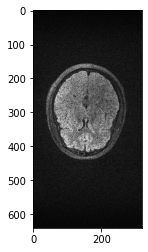

In [9]:
import matplotlib.pyplot as plt

slice = 3

plt.imshow(image_grappa[slice,:,:],cmap='gray')


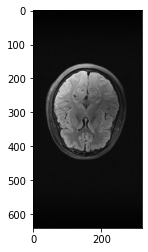

In [10]:
plt.imshow(image_GT[slice,:,:],cmap='gray')


In [11]:
# Compare with overfitted NN output

import tensorflow as tf
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Input,BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.layers import PReLU, LeakyReLU, add, Attention, Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

crop_size = (12,640,320)

model = None
kernel_size = (3,3)
loss_weights = [1.0, 0.0001, 0.000001]

selected_layers = ['block1_conv1', 'block2_conv2', 'block3_conv3' ,'block4_conv3']
selected_layer_weights_content = [0.001, 0.01, 2, 4]

vgg = VGG19(weights='imagenet', include_top=False, input_shape=(crop_size[1],crop_size[2],3))
vgg.trainable = False

outputs = [vgg.get_layer(l).output for l in selected_layers]
vgg_model = Model(vgg.input, outputs)
vgg_model.trainable = False

def model_loss_all(y_true, y_pred):
    global vgg_model
    global loss_weights
    global selected_layer_weights_content
    
    # Remove abs() from the ssim loss
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(img1=y_true,img2=y_pred,max_val=1.0,filter_size=3,filter_sigma=0.1))
    pixel_loss = tf.reduce_mean(tf.math.abs(y_true-y_pred))
    
    content_loss = 0.0
    res_y_rss = tf.image.grayscale_to_rgb(y_true*255)
    res_y_rss = preprocess_input(res_y_rss)
    vgg_f_gt = vgg_model(res_y_rss)

    res_y_pred = tf.image.grayscale_to_rgb(y_pred*255)
    res_y_pred = preprocess_input(res_y_pred)
    vgg_f_pred = vgg_model(res_y_pred)

    for h1, h2, cw in zip(vgg_f_gt, vgg_f_pred, selected_layer_weights_content):
        content_loss = content_loss + cw *tf.reduce_mean(tf.square(tf.math.abs(tf.cast(h1,tf.float32) - tf.cast(h2,tf.float32))))
    
    return loss_weights[0]*ssim_loss+loss_weights[1]*pixel_loss +loss_weights[2]*content_loss

def conv_block(ip, nfilters, drop_rate):
    
    layer_top = Conv2D(nfilters, (3,3), padding = "same")(ip)
    layer_top = BatchNormalization()(layer_top)

    res_model = LeakyReLU()(layer_top)
    res_model = Dropout(drop_rate)(res_model)
    
    res_model = Conv2D(nfilters, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization()(res_model)

    res_model = Dropout(drop_rate)(res_model)
    res_model = add([layer_top,res_model])
    res_model = LeakyReLU()(res_model)
    return res_model

def encoder(inp, nlayers, nbasefilters, drop_rate):
    
    skip_layers = []
    layers = inp
    for i in range(nlayers):
        layers = conv_block(layers,nbasefilters*2**i,drop_rate)
        
        # Attention layer
        #layers = Attention()([layers,layers])
        
        skip_layers.append(layers)
        layers = MaxPooling2D((2,2))(layers)
    return layers, skip_layers

def decoder(inp, nlayers, nbasefilters,skip_layers, drop_rate):
    
    layers = inp
    for i in range(nlayers):
        layers = conv_block(layers,nbasefilters*(2**(nlayers-1-i)),drop_rate)
        
        # Attention layer
        #layers=Attention()([layers,layers])
        
        layers=Conv2DTranspose(kernel_size=(2,2),filters=nbasefilters*(2**(nlayers-1-i)),strides=(2,2), padding='same')(layers)
        layers=add([layers,skip_layers.pop()])
    return layers

def create_gen(gen_ip, nlayers, nbasefilters, drop_rate):
    op,skip_layers = encoder(gen_ip,nlayers, nbasefilters,drop_rate)
    op = decoder(op,nlayers, nbasefilters,skip_layers,drop_rate)
    op = Conv2D(1, (3,3), padding = "same")(op)
    # Add sigmoid activation layer to force output images to have pixel values [0,1]
    op = Activation('sigmoid', dtype='float32')(op)
    return Model(inputs=gen_ip,outputs=op)

input_shape = (crop_size[1],crop_size[2],crop_size[0])
input_layer = Input(shape=input_shape)
model = create_gen(input_layer,5,32,0.01)


In [12]:
model.load_weights('/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Models/Overfitted_DeepMRIRec_GPU.h5')


In [15]:
reconstructed_image = model.predict(image_grappa_mc)
reconstructed_image = reconstructed_image[:,:,:,0]


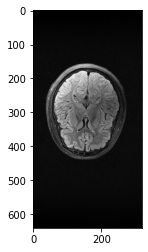

In [16]:
plt.imshow(reconstructed_image[slice,:,:],cmap='gray')


In [17]:
compute_rmse(image_GT,reconstructed_image)


0.033450127

In [18]:
nmse(image_GT,reconstructed_image)


array(0.02575225)

In [19]:
psnr(image_GT,reconstructed_image)


29.512044359312686

In [20]:
ssim(image_GT,reconstructed_image)


array([0.84451066])

In [21]:
ssim_tf(image_GT,reconstructed_image)


<tf.Tensor: shape=(), dtype=float32, numpy=0.94006795>